# Analiz

In [336]:
import pandas as pd
import numpy as np
df = pd.read_csv("sales.csv")
df

,order_id,date,item_name,item_type,item_price,quantity,transaction_amount,transaction_type,received_by,time_of_sale
0,1,07-03-2022,Aalopuri,Fastfood,20,13,260,NaN,Mr.,Night
1,2,8/23/2022,Vadapav,Fastfood,20,15,300,Cash,Mr.,Afternoon
2,3,11/20/2022,Vadapav,Fastfood,20,1,20,Cash,Mr.,Afternoon
3,4,02-03-2023,Sugarcane juice,Beverages,25,6,150,Online,Mr.,Night
4,5,10-02-2022,Sugarcane juice,Beverages,25,8,200,Online,Mr.,Evening
...,...,...,...,...,...,...,...,...,...,...
995,996,3/19/2023,Frankie,Fastfood,50,10,500,NaN,Mrs.,Evening
996,997,9/20/2022,Sandwich,Fastfood,60,7,420,NaN,Mr.,Evening
997,998,1/26/2023,Sandwich,Fastfood,60,13,780,NaN,Mr.,Evening
998,999,8/27/2022,Panipuri,Fastfood,20,5,100,NaN,Mrs.,Afternoon


Veri kümesi 1000 satır ve 10 sütun içermektedir. 
Veri kümesinin her satırı bir siparişe ilişkin bilgileri içerir.

Amacımız, veri kümemizde bulunan bilgileri kullanarak "quantity" (miktar) sütunundaki değerleri tahmin etmektir. Bu tahminleme süreci, sipariş tarihi, ürün adı, ürün tipi, fiyatı, işlem tipi gibi diğer sütunlardaki verilerin analizine dayanacaktır.

Her sütun için veri türünü kontrol edelim:

In [337]:
df.dtypes

order_id               int64
date                  object
item_name             object
item_type             object
item_price             int64
quantity               int64
transaction_amount     int64
transaction_type      object
received_by           object
time_of_sale          object
dtype: object

In [338]:
df.describe()

,order_id,item_price,quantity,transaction_amount
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,33.315000,8.162000,275.230000
std,288.819436,14.921744,4.413075,204.402979
min,1.000000,20.000000,1.000000,20.000000
25%,250.750000,20.000000,4.000000,120.000000
50%,500.500000,25.000000,8.000000,240.000000
75%,750.250000,50.000000,12.000000,360.000000
max,1000.000000,60.000000,15.000000,900.000000


Satışlarımızı vakit'e göre inceleyelim;

In [339]:
import plotly.express as px

fig = px.histogram(df, x="item_name", y="quantity", marginal="box", title="Yemek Satışları (Vakit)", color="time_of_sale")
fig.update_layout(bargap=0.1)
fig.show()

Yiyecek ve içecek satışlarını vakit'e göre incelediğimizde satışlar birbirine çok yakındır.

In [340]:
pd.pivot_table(df, columns='time_of_sale', index='item_name', values='quantity', aggfunc='sum')

time_of_sale,Afternoon,Evening,Midnight,Morning,Night
item_name,,,,,
Aalopuri,226,136,223,215,244
Cold coffee,337,235,203,287,299
Frankie,238,240,198,204,270
Panipuri,230,241,278,233,244
Sandwich,164,206,201,234,292
Sugarcane juice,325,283,237,206,227
Vadapav,194,199,235,195,183


# Ön İşleme

In [341]:
# Tarih sütunundan yıl, ay ve gün bilgilerini çıkararak yeni sütunlar ekleme
df["date"] = df["date"].str.replace("/", "-")
date = pd.to_datetime(df["date"])
df['year'] = date.dt.year
df['month'] = date.dt.month
df['day'] = date.dt.day
df = df.drop(["date"], axis=1)

Boş değer olmadığından bu adımın mağaza satış veri kümesi için gerekli olmadığını unutmayın. Ayrıca, dağılımlarına bağlı olarak farklı sütunlara farklı bir atama stratejisi uygulayabiliriz (örneğin, normal dağılım için ortalama ve üstel dağılım için medyan).

Ayrıca değerleri (0, 1) aralığına ölçeklendirelim.

In [342]:
from sklearn import preprocessing

categorical_columns = ['item_name', 'item_type', 'transaction_type', 'received_by', 'time_of_sale']
# Kategorik verileri one-hot encoding ile dönüştürme
enc = preprocessing.OneHotEncoder()
encoded_categorical_columns = enc.fit_transform(df[categorical_columns])
encoded_feature_names = enc.get_feature_names_out(categorical_columns)
encoded_categorical_df = pd.DataFrame(encoded_categorical_columns.toarray(), columns=encoded_feature_names)

df = df.drop(categorical_columns, axis=1)
df = pd.concat([df, encoded_categorical_df], axis=1)

0

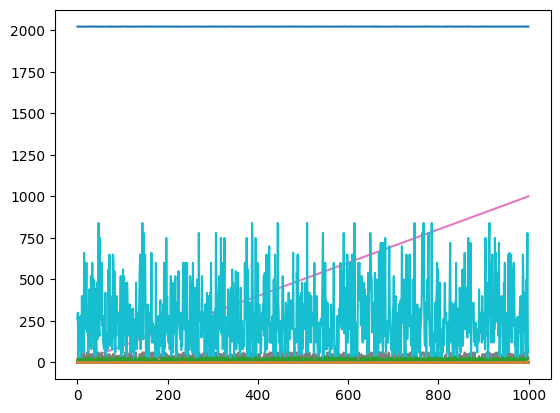

In [343]:
from scipy import stats
import matplotlib.pyplot as plt

# Outlier'ların Z-skoru yöntemi ile belirlenmesi ve işlenmesi
z_scores = np.abs(stats.zscore(df))
plt.plot(z_scores)
df = df[(z_scores < 3).all(axis=1)]
plt.plot(df)
len(df) - len(df)

In [344]:
from sklearn.preprocessing import MinMaxScaler

numeric_cols = df.select_dtypes(np.number).columns
scaler = MinMaxScaler().fit(df[numeric_cols])
df[numeric_cols] = scaler.transform(df[numeric_cols])

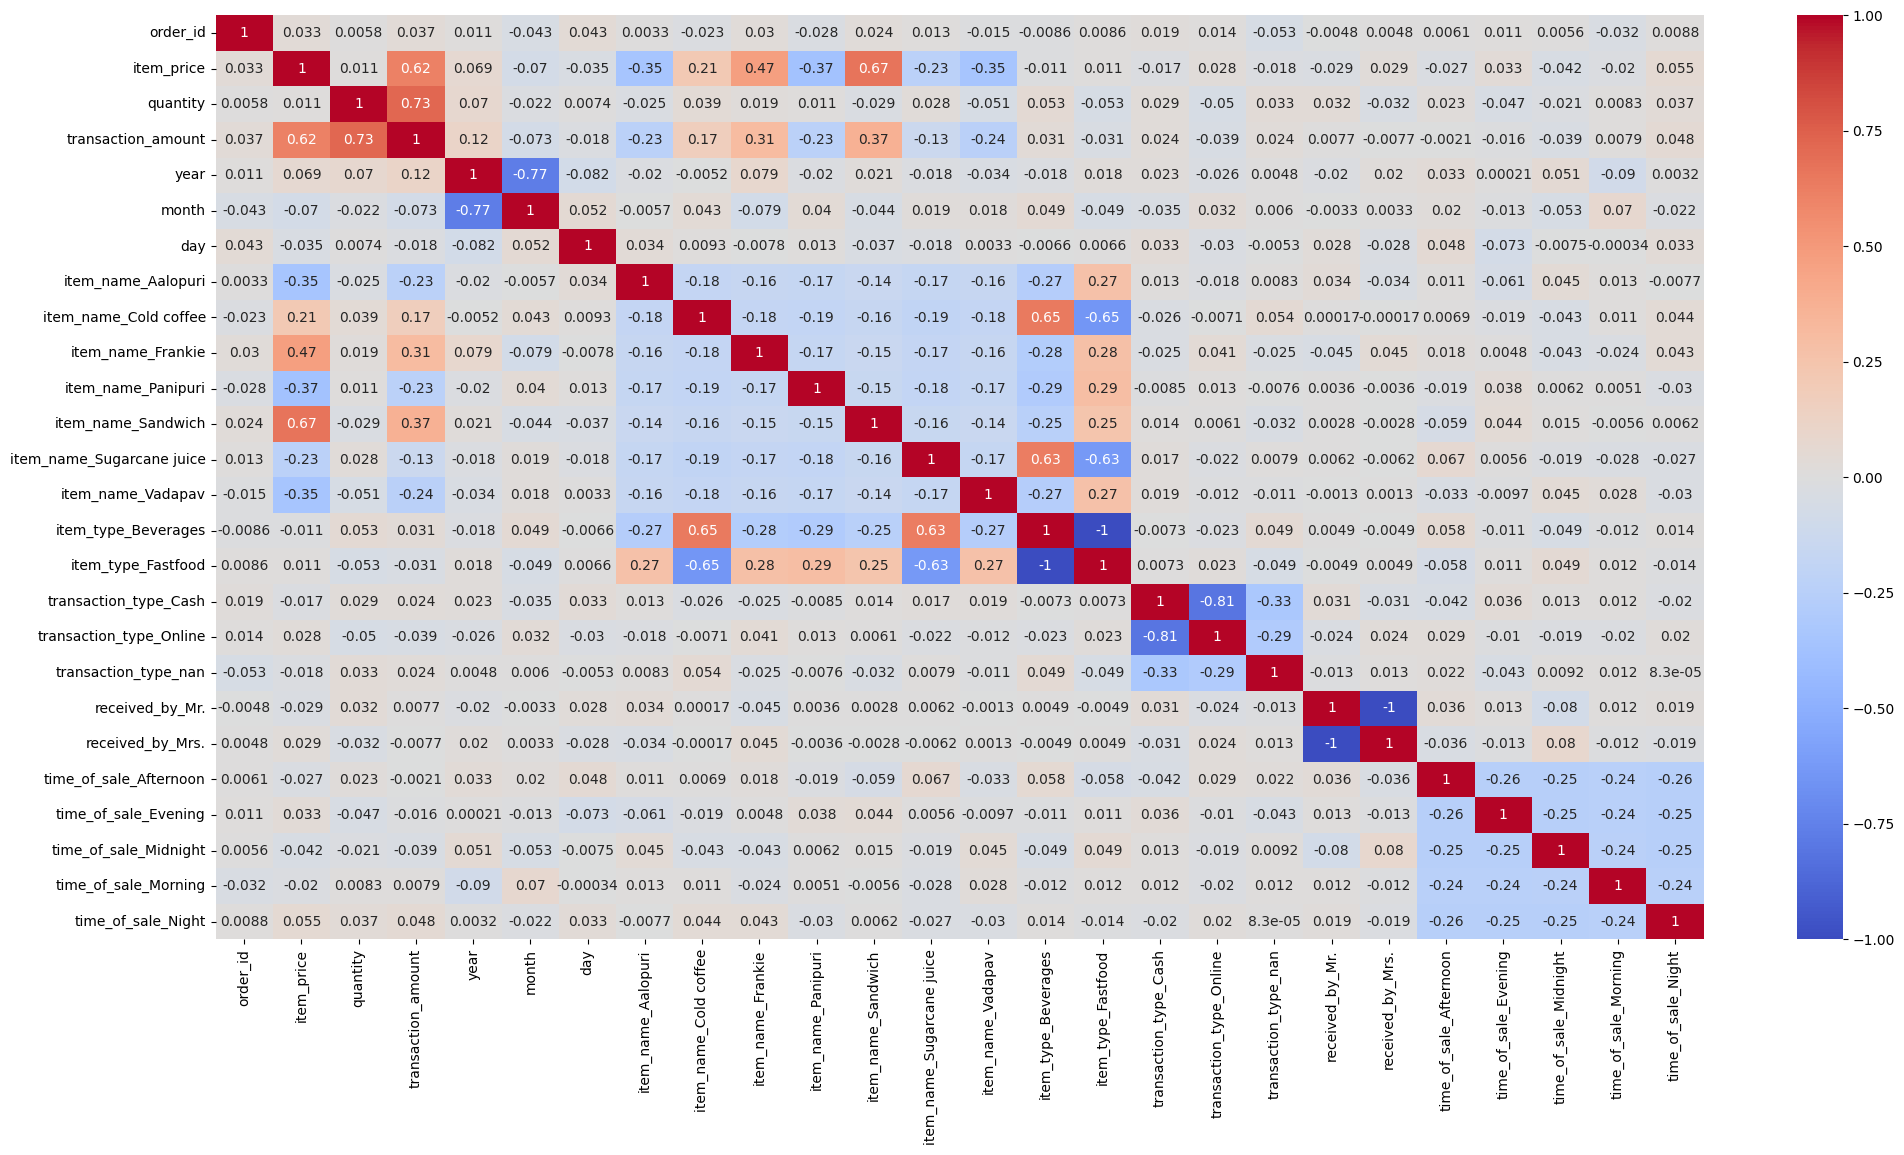

In [345]:
plt.figure(figsize=(24, 12))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

In [346]:
# Hedef değişken ve açıklayıcı değişkenlerin ayrılması
X = df.drop(['quantity','order_id'], axis=1)
y = df['quantity']

In [347]:
print("x", X)
print("y", y)

x      item_price  transaction_amount  year     month       day   
0         0.000            0.292683   0.0  0.545455  0.066667  \
1         0.000            0.341463   0.0  0.636364  0.733333   
2         0.000            0.000000   0.0  0.909091  0.633333   
3         0.125            0.158537   1.0  0.090909  0.066667   
4         0.125            0.219512   0.0  0.818182  0.033333   
..          ...                 ...   ...       ...       ...   
995       0.750            0.585366   1.0  0.181818  0.600000   
996       1.000            0.487805   0.0  0.727273  0.633333   
997       1.000            0.926829   1.0  0.000000  0.833333   
998       0.000            0.097561   0.0  0.636364  0.866667   
999       0.000            0.048780   0.0  0.363636  0.933333   

     item_name_Aalopuri  item_name_Cold coffee  item_name_Frankie   
0                   1.0                    0.0                0.0  \
1                   0.0                    0.0                0.0   
2         

In [348]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeli seçme ve eğitme
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test verisi üzerinde tahmin yapma
y_pred = model.predict(X_test)

# Model performansını değerlendirme
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

c:\Users\ismai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



0.0030507965037608296

In [349]:
df

,order_id,item_price,quantity,transaction_amount,year,month,day,item_name_Aalopuri,item_name_Cold coffee,item_name_Frankie,...,transaction_type_Cash,transaction_type_Online,transaction_type_nan,received_by_Mr.,received_by_Mrs.,time_of_sale_Afternoon,time_of_sale_Evening,time_of_sale_Midnight,time_of_sale_Morning,time_of_sale_Night
0,0.000000,0.000,0.857143,0.292683,0.0,0.545455,0.066667,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.001001,0.000,1.000000,0.341463,0.0,0.636364,0.733333,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.002002,0.000,0.000000,0.000000,0.0,0.909091,0.633333,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.003003,0.125,0.357143,0.158537,1.0,0.090909,0.066667,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.004004,0.125,0.500000,0.219512,0.0,0.818182,0.033333,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.995996,0.750,0.642857,0.585366,1.0,0.181818,0.600000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
996,0.996997,1.000,0.428571,0.487805,0.0,0.727273,0.633333,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
997,0.997998,1.000,0.857143,0.926829,1.0,0.000000,0.833333,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
998,0.998999,0.000,0.285714,0.097561,0.0,0.636364,0.866667,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
